In [6]:
################i tested rbm from the guy in github, this code has implemented the exact pper from hinton.

import glob
import tensorflow as tf
from tensorflow.python.ops import control_flow_ops
from progressbar import ProgressBar
import h5py
import matplotlib.pyplot as plt
I=0
def _parse_function(example_proto):
    features = {"X": tf.FixedLenFeature((257), tf.float32),
              "Y": tf.FixedLenFeature((257), tf.float32)}
    parsed_features = tf.parse_single_example(example_proto, features)
    return parsed_features["X"], parsed_features["Y"]

def rbm_layer(n_visible, n_hidden, num_epochs, num_cases, lr, ws, bs, layer_n, len_data, directories):
    
    Data_path = directories[0]
    tfrecord_folder_parent = directories[1]
    tfrecord_folder = directories[2]
    
    tfrecord_path_x = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
    sorted_names_x = natsorted(os.listdir(tfrecord_path_x))
    trainfilenames_x = []
    for i in sorted_names_x:
        trainfilenames_x.append(os.path.normpath(os.path.join(tfrecord_path_x,i)))
#     filenames_x = tf.placeholder(tf.string, shape=[None])
    dataset_x = tf.data.TFRecordDataset(trainfilenames_x)
    dataset_x = dataset_x.map(_parse_function)  # Parse the record into tensors.
#     dataset_x = dataset_x.repeat()  # Repeat the input indefinitely.
    dataset_x = dataset_x.batch(batch_size)
#     iterator_x = dataset_x.make_initializable_iterator()

#     x  = tf.placeholder(tf.float32, [None, n_visible], name="x") #The placeholder variable that holds our data
    W  = tf.Variable(tf.random_normal([n_visible, n_hidden], 0.01), name="W") #The weight matrix that stores the edge weights
    bh = tf.Variable(tf.zeros([1, n_hidden],  tf.float32, name="bh")) #The bias vector for the hidden layer
    bv = tf.Variable(tf.zeros([1, n_visible],  tf.float32, name="bv")) #The bias vector for the visible layer
    
    W_adder  = tf.zeros((n_visible,n_hidden),dtype=tf.dtypes.float32)
    bh_adder = tf.zeros((1,n_hidden),dtype=tf.dtypes.float32)
    bv_adder = tf.zeros((1,n_visible),dtype=tf.dtypes.float32)
    
#     weight_decay = 0.001
#     initialmomentum  = 0.5
#     finalmomentum    = 0.9
    
    weight_decay = 0
    initialmomentum  = 0
    finalmomentum    = 0   
    def sample(probs):
        #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
        return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))


    def gibbs_sample(k,data):
        #Runs a k-step gibbs chain to sample from the probability distribution of the RBM defined by W, bh, bv
        def gibbs_step(count, k, data):
            #Runs a single gibbs step. The visible values are initialized to xk
#             hk = sample(tf.tanh(tf.matmul(data, W) + bh)) #Propagate the visible values to sample the hidden values
            hk = sample(tf.tanh(tf.matmul(data+ tf.random.normal((len(data),len(data[0])),mean=0.0,stddev=1), W) + bh))
#             hk = sample(tf.matmul(data, W) + bh)
#             data   = tf.matmul(hk, tf.transpose(W)) + bv+ tf.random.normal((len(x[0]),len(x[0][0])),mean=0.0,stddev=1)
            data   = tf.matmul(hk, tf.transpose(W)) + bv
#             data   = tf.tanh(tf.matmul(hk, tf.transpose(W)) + bv)
#             data = tf.truncated_normal((1,n_visible),tf.matmul(hk, tf.transpose(W)) + bv,1)
            return count+1, k, data
#         print('2')
        ct = tf.constant(0) #counter
        #Run gibbs steps for k iterations
        [_, _, x_sample]=control_flow_ops.while_loop(lambda count, num_iter, *args: count < num_iter,
                                             gibbs_step, [ct, tf.constant(k), data], back_prop = False)
#         print('3')
        #This is not strictly necessary in this implementation, but if you want to adapt this code to use one of TensorFlow's
        #optimizers, you need this in order to stop tensorflow from propagating gradients back through the gibbs step
        x_sample = tf.stop_gradient(x_sample) 
#         print('4')
        return x_sample

    ### Training Update Code
    # Now we implement the contrastive divergence algorithm. First, we get the samples of x and h from the probability distribution
    #The sample of x
#     print('1')
#     x_sample = gibbs_sample(5) 
#     #The sample of the hidden nodes, starting from the visible state of x
#     h = sample(tf.sigmoid(tf.matmul(x, W) + bh)) 
#     #The sample of the hidden nodes, starting from the visible state of x_sample
#     h_sample = sample(tf.sigmoid(tf.matmul(x_sample, W) + bh)) 

#     #Next, we update the values of W, bh, and bv, based on the difference between the samples that we drew and the original values
# #     size_bt = tf.cast(tf.shape(x)[0], tf.float32)
#     W_adder  = tf.multiply(lr, tf.subtract(tf.matmul(tf.transpose(x), h), tf.matmul(tf.transpose(x_sample), h_sample)))
#     bv_adder = tf.multiply(lr, tf.reduce_sum(tf.subtract(x, x_sample), 0, True))
#     bh_adder = tf.multiply(lr, tf.reduce_sum(tf.subtract(h, h_sample), 0, True))
#     #When we do sess.run(updt), TensorFlow will run all 3 update steps
#     updt = [W.assign_add(W_adder), bv.assign_add(bv_adder), bh.assign_add(bh_adder)]



    ### Run the graph!
    # Now it's time to start a session and run the graph! 

    incount=0
    k=0
    pbar = ProgressBar()
    errsum = []
    
    for epoch in pbar(range(num_epochs)):
        #Train the RBM on batch_size examples at a time
#             for X_batch in da(batch_size, layer_n, ws, bs, len_data, name, data_name):
        err=0
        for x in dataset_x:
            xx=x[0]
            incount+=1
            if incount%1000==0:
                print(incount)
            if layer_n>1:
                for j in range(1,layer_n):
                    xx = tf.tanh(tf.matmul(xx,ws[j])+bs[j])
#             else:
#                 x_0 = x[0]
            x_sample = gibbs_sample(1,xx) 
            #The sample of the hidden nodes, starting from the visible state of x
            h = sample(tf.tanh(tf.matmul(xx, W) + bh)) 
#             h = sample(tf.matmul(x[0], W) + bh)
            #The sample of the hidden nodes, starting from the visible state of x_sample
            h_sample = sample(tf.tanh(tf.matmul(x_sample, W) + bh)) 
#             h_sample = sample(tf.matmul(x_sample, W) + bh)
            if epoch>5:
                m=finalmomentum
            else:
                m=initialmomentum
            #Next, we update the values of W, bh, and bv, based on the difference between the samples that we drew and the original values
        #     size_bt = tf.cast(tf.shape(x)[0], tf.float32)
            W_adder  = (m * W_adder) + tf.multiply(lr, tf.subtract(tf.matmul(tf.transpose(xx), h), tf.matmul(tf.transpose(x_sample), h_sample)))- W*weight_decay
            bv_adder = (m * bv_adder) + tf.multiply(lr, tf.reduce_sum(tf.subtract(xx, x_sample), 0, True))
            bh_adder = (m * bh_adder) + tf.multiply(lr, tf.reduce_sum(tf.subtract(h, h_sample), 0, True))
            #When we do sess.run(updt), TensorFlow will run all 3 update steps
            err= err+tf.reduce_sum(tf.reduce_sum((xx-x_sample)**2))
            updt = [W.assign_add(W_adder).numpy(), bv.assign_add(bv_adder).numpy(), bh.assign_add(bh_adder).numpy(), errsum]
#             updt = [W.assign_add(W_adder).numpy(), bv.numpy(), bh.numpy()]
        errsum.append(err/100000)
    
    plt.plot(range(num_epochs), errsum)
    plt.show()
    print('zoomed in:')
    plt.plot(range(4,num_epochs), errsum[4:num_epochs])
    plt.show()
    return updt




imported
1000


2000
3000


4000


5000
6000


7000


8000
9000


10000


11000
12000


13000
14000


15000


16000
17000


18000


19000
20000


21000


22000
23000


24000


25000
26000


27000
28000


29000


30000
31000


100% |########################################################################|


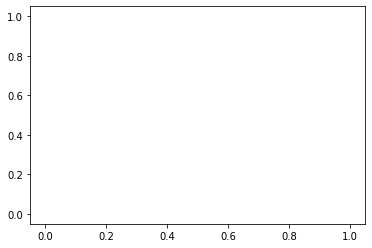

zoomed in:


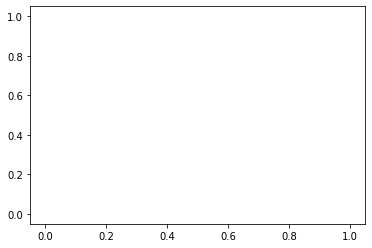

In [7]:
# import libraries.
import numpy as np
from sklearn.utils import shuffle
import tensorflow as tf
import datetime
tf.enable_eager_execution()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# import keras
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from pystoi.stoi import stoi
import h5py
######################
#import libraries.
import matplotlib.pyplot as plt
from tabulate import tabulate
import time
import os
import librosa
from librosa.core import stft, istft
####import sounddevice as sd
import time
print('imported')
# #######################
Data_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff'
# Data_path = os.getcwd()
tfrecord_folder_parent = 'tfrecord_files'
tfrecord_folder = 'mixed_10h_norm'
tfrecord_val_folder = 'validation_mixed_norm'
# ckpt_folder = '3'
dirs = [Data_path, tfrecord_folder_parent, tfrecord_folder]
 
# len_data = (684108, 257)
# len_data = (100000, 257)
# len_data = (2197278, 257)
# val_len = (97278,257)
len_data = (500000, 257)
val_len = (100000,257)
w=1
#######################
#define reconstruct function to reconstruct sound from framed signal.
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=256, win_length=512, window='hann')
    return recon
#######################
I=0
global batch_size
batch_size = 128
# epochs_num=50
global datalen
datalen=len_data[0]

h = [512,512,512,257]
seed = 7
rate1 = 0.1
rate2 = 0.2
# from tensorflow.keras.layers import Activation
# # from keras.layers import Activation
# np.random.seed(seed)
# model = Sequential()
# act1 = layers.LeakyReLU(alpha=0.1)
# model.add(layers.Dropout(rate1, noise_shape=None, seed=None))
# # ,kernel_regularizer=regularizers.l2(0.001)
# model.add(Dense(h[0], input_dim = w*len_data[1]))
# model.add(BatchNormalization())
# model.add(act1)
# # model.add(Activation('sigmoid'))
# act2=layers.LeakyReLU(alpha=0.1)
# model.add(layers.Dropout(rate2, noise_shape=None, seed=None))
# model.add(Dense(h[1]))
# model.add(act2)
# # act3=layers.LeakyReLU(alpha=0.1)
# # # model.add(layers.Dropout(rate, noise_shape=None, seed=None))
# # model.add(Dense(h[2]))
# # model.add(act3)
# act=layers.LeakyReLU(alpha=0.01)
# model.add(Dense(len_data[1]))
#############################################
import os
from natsort import natsorted

# def _parse_function(example_proto):
#     print('1')
#     features = {"X": tf.FixedLenFeature((3*257), tf.float32),
#               "Y": tf.FixedLenFeature((257), tf.float32)}
#     parsed_features = tf.parse_single_example(example_proto, features)
#     print("i was here")
#     print('2')
#     return parsed_features["X"], parsed_features["Y"]

# tfrecord_path = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
# sorted_names = natsorted(os.listdir(tfrecord_path))
# trainfilenames = []
# for i in sorted_names:
#     trainfilenames.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# filenames = tf.placeholder(tf.string, shape=[None])
# dataset = tf.data.TFRecordDataset(filenames)
# dataset = dataset.map(_parse_function)  # Parse the record into tensors.
# dataset = dataset.repeat()  # Repeat the input indefinitely.
# dataset = dataset.batch(batch_size)
# iterator = dataset.make_initializable_iterator()

# # orig_path = os.getcwd()
# tfrecord_path_x = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
# sorted_names_x = natsorted(os.listdir(tfrecord_path_x))
# trainfilenames_x = []
# for i in sorted_names_x:
#     trainfilenames_x.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# filenames_x = tf.placeholder(tf.string, shape=[None])
# dataset_x = tf.data.TFRecordDataset(filenames_x)
# dataset_x = dataset_x.map(_parse_function)  # Parse the record into tensors.
# dataset_x = dataset_x.repeat()  # Repeat the input indefinitely.
# dataset_x = dataset_x.batch(batch_size)
# iterator_x = dataset_x.make_initializable_iterator()

#######################
visible = w*len_data[1]
hidden = h[0]
visible1 = h[0]
hidden1 = h[1]
visible2 = h[1]
hidden2 = h[2]
visible3 = h[2]
hidden3 = h[3]

layer1 = rbm_layer(visible, hidden, 20, batch_size, 0.0001, [np.eye(visible, visible)], [np.zeros((1,visible))], 1, len_data[0],dirs)
# layer2 = rbm_layer(visible1, hidden1, 20, batch_size, 0.00001, [np.eye(visible, visible),layer1[0]], [np.zeros((1,visible)),layer1[2]], 2, len_data[0], dirs)
# layer3 = rbm_layer(visible2, hidden2, 20, batch_size, 0.00001, [np.eye(visible,visible),layer1[0],layer2[0]], [np.zeros((1,visible)),layer1[2],layer2[2]], 3, len_data[0], dirs)
# layer4 = rbm_layer(visible3, hidden3, 20, batch_size, 0.00001, [np.eye(visible,visible),layer1[0],layer2[0],layer[3]], [np.zeros((1,visible)),layer1[2],layer2[2],layer[3]], 4, len_data[0], dirs)

###############################



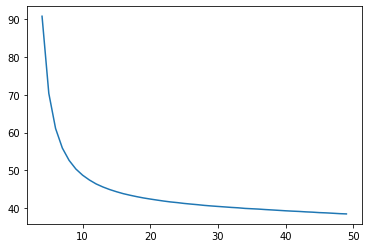

In [38]:
plt.plot(range(4,50), layer1[3][4:])
plt.show()

In [34]:
layer1[3]

[<tf.Tensor: id=5003141, shape=(), dtype=float32, numpy=48993.992>,
 <tf.Tensor: id=5085262, shape=(), dtype=float32, numpy=3299.5447>,
 <tf.Tensor: id=5167383, shape=(), dtype=float32, numpy=498.27252>,
 <tf.Tensor: id=5249504, shape=(), dtype=float32, numpy=156.02788>,
 <tf.Tensor: id=5331625, shape=(), dtype=float32, numpy=90.85684>,
 <tf.Tensor: id=5413746, shape=(), dtype=float32, numpy=70.39419>,
 <tf.Tensor: id=5495867, shape=(), dtype=float32, numpy=61.0814>,
 <tf.Tensor: id=5577988, shape=(), dtype=float32, numpy=55.887653>,
 <tf.Tensor: id=5660109, shape=(), dtype=float32, numpy=52.614014>,
 <tf.Tensor: id=5742230, shape=(), dtype=float32, numpy=50.322826>,
 <tf.Tensor: id=5824351, shape=(), dtype=float32, numpy=48.67836>,
 <tf.Tensor: id=5906472, shape=(), dtype=float32, numpy=47.40805>,
 <tf.Tensor: id=5988593, shape=(), dtype=float32, numpy=46.35858>,
 <tf.Tensor: id=6070714, shape=(), dtype=float32, numpy=45.55414>,
 <tf.Tensor: id=6152835, shape=(), dtype=float32, numpy=

In [105]:
I=0

# epochs_num=50
global datalen
datalen=len_data[0]


seed = 7
rate1 = 0.1
rate2 = 0.2
buffersize = 1000
from tensorflow.keras.layers import Activation
# from keras.layers import Activation
np.random.seed(seed)
act1 = layers.LeakyReLU(alpha=0.1)
model = Sequential()
# model.add(layers.Dropout(rate1, noise_shape=None, seed=None))
# ,kernel_regularizer=regularizers.l2(0.001)
# model.add(Dense(h[0], input_dim = w*len_data[1]))
# model.add(Dense(h[0], input_dim = w*len_data[1], kernel_initializer= 'lecun_uniform', bias_initializer = 'lecun_uniform'))
# model.add(Dense(h[0], input_dim = w*len_data[1], kernel_initializer= tf.constant_initializer(layer1[0]), bias_initializer = tf.constant_initializer(layer1[2])))
# , kernel_initializer= tf.constant_initializer(layer1[0]), bias_initializer = tf.constant_initializer(layer1[2])
# tf.constant_initializer(layer1[0])
# tf.constant_initializer(layer1[2])
# model.add(BatchNormalization())
# model.add(act1)
# model.add(Activation('tanh'))
# act2=layers.LeakyReLU(alpha=0.1)
model.add(Activation('sigmoid'))
# model.add(layers.Dropout(rate2, noise_shape=None, seed=None))
# model.add(Dense(h[1]))
# model.add(act2)
# act3=layers.LeakyReLU(alpha=0.1)
# # model.add(layers.Dropout(rate, noise_shape=None, seed=None))
# model.add(Dense(h[2]))
# model.add(act3)
# act=layers.LeakyReLU(alpha=0.01)
model.add(Dense(len_data[1]))
#############################################
import os

def _parse_function(example_proto):
    features = {"X": tf.FixedLenFeature((w*257), tf.float32),
              "Y": tf.FixedLenFeature((257), tf.float32)}
    parsed_features = tf.parse_single_example(example_proto, features)
    return parsed_features["X"], parsed_features["Y"]

tfrecord_path = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_folder))
sorted_names = natsorted(os.listdir(tfrecord_path))
trainfilenames = []
for i in sorted_names:
    trainfilenames.append(os.path.normpath(os.path.join(tfrecord_path,i)))
# filenames = tf.placeholder(tf.string, shape=[None])
# dataset = tf.data.TFRecordDataset(filenames)
dataset = tf.data.TFRecordDataset(trainfilenames)
dataset = dataset.map(_parse_function)  # Parse the record into tensors.
dataset = dataset.repeat()  # Repeat the input indefinitely.
dataset = dataset.batch(batch_size)
dataset = dataset.shuffle(buffersize)
# iterator = dataset.make_initializable_iterator()

tfrecord_path_val = os.path.normpath(os.path.join(Data_path,tfrecord_folder_parent,tfrecord_val_folder))
sorted_names_val = natsorted(os.listdir(tfrecord_path_val))
trainfilenames_val = []
for i in sorted_names_val:
    trainfilenames_val.append(os.path.normpath(os.path.join(tfrecord_path_val,i)))
# filenames_val = tf.placeholder(tf.string, shape=[None])
# dataset_val = tf.data.TFRecordDataset(filenames_val)
dataset_val = tf.data.TFRecordDataset(trainfilenames_val)
dataset_val = dataset_val.map(_parse_function)  # Parse the record into tensors.
dataset_val = dataset_val.repeat()  # Repeat the input indefinitely.
dataset_val = dataset_val.batch(128)
# iterator_val = dataset_val.make_initializable_iterator()

epochs_num = 50
steps = len_data[0] // batch_size
val_steps = val_len[0] // batch_size
# You can feed the initializer with the appropriate filenames for the current
# phase of execution, e.g. training vs. validation.
# next_elem = iterator_val.get_next()
# Initialize `iterator` with training data.

if not os.path.exists(os.path.join(Data_path,"checkpoints",ckpt_folder)):
    os.makedirs(os.path.join(Data_path,"checkpoints",ckpt_folder))

print(datetime.datetime.now())
# with tf.Session() as sess:
#     sess.run(tf.global_variables_initializer())
#     sess.run(iterator.initializer, feed_dict={filenames: trainfilenames})
#     sess.run(iterator_val.initializer, feed_dict={filenames_val: trainfilenames_val})
print("initialized")
checkpoint_path = os.path.normpath(os.path.join(Data_path,"checkpoints",ckpt_folder,"weights.{epoch:02d}.hdf5"))
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_best_only=True, save_weights_only=True)
        # Save weights, every 5-epochs.
#         period=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
opt = tf.keras.optimizers.Adamax()
# opt = tf.train.AdamOptimizer()
# opt = tf.keras.optimizers.SGD()
model.compile(loss='mean_squared_error', optimizer=opt)
history = model.fit( dataset, steps_per_epoch=steps,epochs=epochs_num, callbacks = [cp_callback,early_stop], verbose=1,validation_data=dataset_val,validation_steps=val_steps)
#     model.save(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
#     tf.keras.models.save_model(model, os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
#     model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_3h_dataset.h5")))
model_json = model.to_json()
with open(os.path.normpath(os.path.join(Data_path, 'models', "model_"+ckpt_folder+".json")), "w") as json_file:
    json_file.write(model_json)
# # serialize weights to HDF5
model.save_weights(os.path.normpath(os.path.join(Data_path, 'models', "model_"+ckpt_folder+".h5")))
print("Saved model to disk")
    
print(datetime.datetime.now())
%matplotlib inline
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
plt.savefig(os.path.normpath(os.path.join(Data_path,'images',ckpt_folder+'.png')))
# model_json = model.to_json()
# with open("model_10h_dataset.json", "w") as json_file:
#     json_file.write(model_json)
# model.save_weights("model_10h_dataset.h5")
# print("Saved model to disk")

2019-07-16 19:19:48.115610
initialized
Epoch 1/50
781/781 [==============================] - 4s 5ms/step - loss: 1.5745

Epoch 00001: val_loss improved from inf to 1.57449, saving model to D:\studies\university\thesis\speech_separation_codes\du16\donesomestuff\checkpoints\3\weights.01.hdf5
781/781 [==============================] - 14s 18ms/step - loss: 2.0359 - val_loss: 1.5745
Epoch 2/50
424/781 [===============>..............] - ETA: 2s - loss: 1.4739

Exception ignored in: <bound method EagerResourceDeleter.__del__ of <tensorflow.python.ops.resource_variable_ops.EagerResourceDeleter object at 0x00000204F1C09898>>
Traceback (most recent call last):
  File "C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\resource_variable_ops.py", line 139, in __del__
    self._handle, ignore_lookup_error=True)
  File "C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\tensorflow\python\ops\gen_resource_variable_ops.py", line 300, in destroy_resource_op
    "ignore_lookup_error", ignore_lookup_error)
KeyboardInterrupt: 


KeyboardInterrupt: 

In [9]:
def sample(probs):
    #Takes in a vector of probabilities, and returns a random vector of 0s and 1s sampled from the input vector
    return tf.floor(probs + tf.random_uniform(tf.shape(probs), 0, 1))

In [3]:
write_path = 'D:/studies/university/thesis/speech_separation_codes/du16/donesomestuff/10hdata'
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_norm'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr = h5f['mixed_log_10h_norm'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_phase_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_phase = h5f['mixed_phase_10h_nozeroinsert'][0:126]
h5f.close()
mixed_folder = os.path.normpath(os.path.join(write_path,'mixed_log_10h_nozeroinsert'))
h5f = h5py.File(mixed_folder+'.hdf5','r')
ftr_raw = h5f['mixed_log_10h_nozeroinsert'][0:126]
h5f.close()

In [19]:
layer2[2].shape

(1, 512)

In [11]:
hidden1 = np.matmul(ftr,layer1[0])+layer1[2]
hidden2 = np.matmul(hidden1,layer2[0])+layer2[2]
hidden3 = np.matmul(hidden2,layer3[0])+layer3[2]
hidden3_b = np.matmul(hidden3,layer3[0].T)+layer3[1]
hidden2_b = np.matmul(hidden3_b,layer2[0].T)+layer2[1]
hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]

NameError: name 'layer2' is not defined

In [4]:
def relu(x):
    return x * (x > 0)
# hidden1 = 1/(1+np.exp(-np.matmul(ftr,layer1[0])+layer1[2]))
# hidden2 = 1/(1+np.exp(-np.matmul(hidden1,layer2[0])+layer2[2]))
# hidden3 = 1/(1+np.exp(-np.matmul(hidden2,layer3[0])+layer3[2]))
hidden1 = np.tanh(np.matmul(ftr,layer1[0])+layer1[2])
hidden2 = np.tanh(np.matmul(hidden1,layer2[0])+layer2[2])
hidden3 = np.tanh(np.matmul(hidden2,layer3[0])+layer3[2])
hidden3_b = np.matmul(hidden3,layer3[0].T)+layer3[1]
hidden2_b = np.matmul(hidden3_b,layer2[0].T)+layer2[1]
hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]

In [43]:
# hidden1 = 1/(1+np.exp(-np.matmul(ftr,layer1[0])+layer1[2]))
def leaky_relu(x, alpha):
    output = np.where(x > 0, x, x * alpha)
    return output
hidden1 = np.tanh(np.matmul(ftr,layer1[0])+layer1[2])
# hidden2 = 1/(1+np.exp(-np.matmul(hidden1,layer2[0])+layer2[2]))
print(hidden1.shape)
hidden2 = np.tanh(np.matmul(hidden1,layer2[0])+layer2[2])
# hidden3 = 1/(1+np.exp(-np.matmul(hidden2,layer3[0])+layer3[2]))
hidden2_b = np.matmul(hidden2,layer2[0].T)+layer2[1]
hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]
# hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]

(126, 512)


In [8]:
def relu(x):
    return x * (x > 0)
def leaky_relu(x, alpha):
    output = np.where(x > 0, x, x * alpha)
    return output
# hidden1 = 1/(1+np.exp(-np.matmul(ftr,layer1[0])+layer1[2]))
hidden1 = np.tanh(np.matmul(ftr,layer1[0])+layer1[2])
# hidden2 = 1/(1+np.exp(-np.matmul(hidden1,layer2[0])+layer2[2]))
# hidden3 = 1/(1+np.exp(-np.matmul(hidden2,layer3[0])+layer3[2]))
hidden1_b = np.matmul(hidden1,layer1[0].T)+layer1[1]
# hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]
# hidden1_b = np.matmul(hidden2_b,layer1[0].T)+layer1[1]

In [9]:
hidden1_b

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

In [7]:
ftr

array([[-0.16172186, -1.7788432 , -0.39018264, ..., -1.6597615 ,
        -0.90431803, -0.45906612],
       [-0.0668347 , -0.28278783, -0.29795218, ..., -1.984158  ,
        -1.311973  , -1.1100224 ],
       [ 0.1633877 ,  0.08443733, -0.4262945 , ..., -0.9554962 ,
        -0.93476564, -0.80358255],
       ...,
       [-1.0645881 ,  0.14120764, -0.45629025, ...,  0.28538626,
         0.11404049, -0.8666614 ],
       [ 0.16425018,  0.00892877, -0.34537208, ..., -0.9353687 ,
        -0.81345695, -0.4461429 ],
       [ 0.16982023, -0.05551087, -0.20826632, ..., -0.288958  ,
        -0.92982405, -0.9446395 ]], dtype=float32)

C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in power
C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in multiply
C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\matplotlib\mlab.py:138: RuntimeWarning: invalid value encountered in multiply
  return windowValsRep * x, windowVals
C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\matplotlib\image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\matplotlib\image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\matplotlib\image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
C:\Users\ASUS\Anaconda3\envs\myenv\lib\site-packages\matplotlib\imag

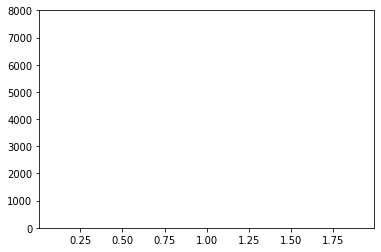

In [5]:
mean = np.loadtxt(os.path.normpath(os.path.join(write_path,'mean_mixed_log.txt')))
std = np.loadtxt(os.path.normpath(os.path.join(write_path,'std_mixed_log.txt')))
hidden1_b_unnorm = (hidden1_b*std)+mean
recon = reconstruct(hidden1_b_unnorm, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)

Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()



In [49]:
import soundfile as sf
sf.write('D:\\studies\\university\\thesis\\speech_separation_codes\\du16\\donesomestuff\\results\\rbm\\1\\3layer_sig_hid_lin_vis_noise_in_gibbs_x.wav',recon,16000)

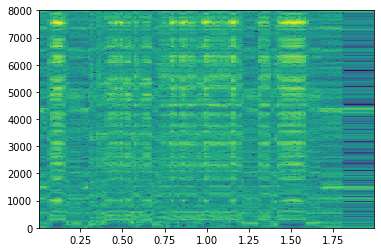

In [33]:
recon = reconstruct(hidden1_b, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)
Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
plt.show()

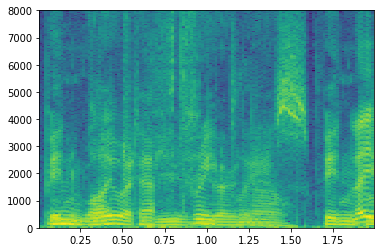

In [39]:
recon = reconstruct(ftr_raw, ftr_phase)
import sounddevice as sd
sd.play(recon,16000)
from scipy import signal
# frequencies, times, spectrogram = signal.spectrogram(recon, 16000)
# plt.pcolormesh(times, frequencies, spectrogram)
# plt.imshow(spectrogram)
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.pcolormesh
# plt.show()
Pxx, freqs, bins, im = plt.specgram(recon, NFFT=512, Fs=16000, noverlap=256)
# The `specgram` method returns 4 objects. They are:
# - Pxx: the periodogram
# - freqs: the frequency vector
# - bins: the centers of the time bins
# - im: the matplotlib.image.AxesImage instance representing the data in the plot
plt.show()

In [97]:
import h5py 
import tensorflow as tf
hh = h5py.File('ftr_refrmd_10h.hdf5', 'r')
d=hh['ftr_refrmd_10h'][0]
len_data=d.shape
hh.close()
len_data

(771,)

In [99]:
def reconstruct(wave,angle):
    recon = np.sqrt(np.power(10, wave))
    recon1 = recon*np.cos(angle)+recon*np.sin(angle)*1j
    recon = librosa.core.istft((recon1.T), hop_length=256, win_length=512, window='hann')
    return recon

In [92]:
dataset

<PrefetchDataset shapes: ((?, 257), (?,)), types: (tf.float32, tf.float32)>